# **Shallow Neural Network -- Numpy Implementation**

> **Summary**
In this notebook, one builts a **Shalow (one layer) Neural Network** for a planar binary classification problem. The implementation is done from scratch with the help of the *numpy* python package, the use of machine learning libraries/frameworks will be covered in other notebooks.

> **Important to mention**: This notebook comes as an additional practice problem following the Deep Learning Specialization provided by deeplearning.ai on Coursera.

> **Author**: Andrei Buiciuc, UBB Cluj-Napoca

### **Overview**

* **Problem statement:** Given a planar dataset, one wants to correctly classify points between two labels using a shallow neural network with one hidden layer.
* **Approach:** Before starting the model implementation, functions for both plotting the model's decision boundary and generating planar datasets will be defined.

---


* **Note:** Because of the use of Google Colab, Drive has to be mounted on the runtime.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

print('Setup complete')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete


### **Prepare the data** ###

Define a helper function that plots the model's decision boundary. Plotting and data visualization is done using the *matplotlib* library for Python.

In [2]:
def plot_decision_boundary(X, Y, model_predict, ax=None, fill=True):
  """
  Helper function to plot the decision boundary.

  Arguments:
  X : the dataset of shape: (input size = n_x, number of examples)
  Y : labels vector of shape: (output size = n_y, number of examples)
  model_predict : reference to the function that predicts
                  (used in the context of a lambda function) 
  """

  x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
  y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
  h = .01

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  
  Z = model_predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  
  if fill is True:
    if ax is None:
      plt.contourf(xx, yy, Z, cmap=plt.cm.viridis)
    else:
      ax.contourf(xx, yy, Z, cmap=plt.cm.viridis)
  else:
    if ax is None:
      plt.contour(xx, yy, Z, cmap=plt.cm.viridis)
    else:
      ax.contour(xx, yy, Z, cmap=plt.cm.viridis)

  if ax is None:
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.viridis)
  else:
    ax.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.viridis)

The datasets are generated using inbuilt methods from the *sklearn* module.

In [3]:
def load_datasets(n_examples):
  """
  Helper function to generate toy datasets.
  
  Arguments:
  n_examples : the number of examples = the size of the input data

  Returns:
  datasets: dictionary containing different sklearn planar datasets
  """

  moons = sklearn.datasets.make_moons(n_examples, noise=0.2, random_state=1)
  circles = sklearn.datasets.make_circles(n_examples, noise=0.1, factor=.6)
  blobs = sklearn.datasets.make_blobs(n_examples, centers=2, cluster_std=3, random_state=22)
  gaussian = sklearn.datasets.make_gaussian_quantiles(n_samples=n_examples, cov=10 ,n_classes=2)
  datasets = {"moons": moons, "circles": circles, "blobs":blobs, "gaussian": gaussian}

  return datasets

In [4]:
# Load a dataset previously created
n_examples = 300
dataset = load_datasets(n_examples )["blobs"]

# Extract the feature vector and the label vector.
X_orig = dataset[0]
Y_orig = dataset[1]

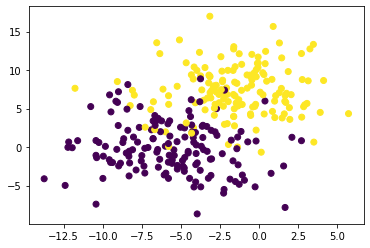

In [5]:
# Visualize the data
plt.scatter(X_orig[:, 0], X_orig[:, 1], c=Y_orig, cmap=plt.cm.viridis)
plt.show()

In [6]:
# Check the dimensions

print("The original shape of X: ", X_orig.shape)
print("The original shape of Y: ", Y_orig.shape)
print("Number of training examples: ", n_examples)

X = X_orig.T
Y = Y_orig.reshape((1, n_examples))

print("\nThe new shape of X(for model implementation): ", X.shape)
print("The new shape of Y(for model implementation): ", Y.shape)

The original shape of X:  (300, 2)
The original shape of Y:  (300,)
Number of training examples:  300

The new shape of X(for model implementation):  (2, 300)
The new shape of Y(for model implementation):  (1, 300)


### **Shallow Neural Network Model**
After the generated dataset has been prepared, one can build a simple Shallow Neural Network with only one hidden layer. 

**Steps:**
* Define the size of the neural network: in this case, the dimension of the 
hidden layer.
* Initialize the parameters W1, b1, W2 and b2: use **Xavier initialization**
* Forward propagation:
  * Compute Z1: the value before the first activation
  * Compute A1: the value after the first activation (using *tanh*)
  * Compute Z2: the value before the second activation
  * Compute A2: the value after the second activation (using *sigmoid*)
* Compute the **cost:** the cross entropy cost, add **L2 regularization**
* Backward propagation:
  * Compute the **gradients**: dW2, db2, dW1, db1
* Gradient descent: **update the parameters** with the update rule

This neural network has the hyperbolic tangent and the sigmoid as activations in the hidden and, respectively, the output layer. In almost all cases, the *tanh* function works better than the sigmoid and is usually used in the hidden layers as it has steeper gradients, therefore convergence is faster. Though, both functions suffer from the vanishing/exploding gradients problem, which can be solved using *ReLU* as activation in the hidden layers or by careful weight intialization. 

In [7]:
def sigmoid(Z):
  """
  Helper function to compute the sigmoid.

  Arguments:
  Z : numpy array

  Returns:
  a numpy array with values through the sigmoid(element wise)
  """

  return 1 / (1 + np.exp(-Z))

In [8]:
def tanh(Z):
  """
  Helper function to compute the hyperbolic tangent.

  Arguments:
  Z : numpy array

  Returns:
  a numpy array with values through the hyperbolic tangent(element wise)
  """
  return np.tanh(Z)

By plotting the two activations and their derivatives, it is obvious that the derivative of *tanh* is much steeper than the derivative of *sigmoid*. If the data is well-centered the gradients will be bigger and the update in gradient descent more significant when using *tanh*.

In [9]:
def plot_activations(fig, a, function_first, function_second, index, _label1, _label2):
  """
  Helper function to plot the activation functions used for the current model.

  Arguments:
  fig : pyplot Figure instance
  a : numpy array with evenly spaced numbers over an interval
  function_first : reference to a lambda function
  function_second : reference to a lambda function
  index : index position in the grid
  _label1 : label for the first function
  _label2 : label for the second function
  """
  ax = fig.add_subplot(1, 3, index)
  ax.plot(a, function_first(a), 'b', label=_label1)
  ax.plot(a, function_second(a), 'r', label=_label2)
  ax.grid(b=True)
  ax.legend(loc="upper left")

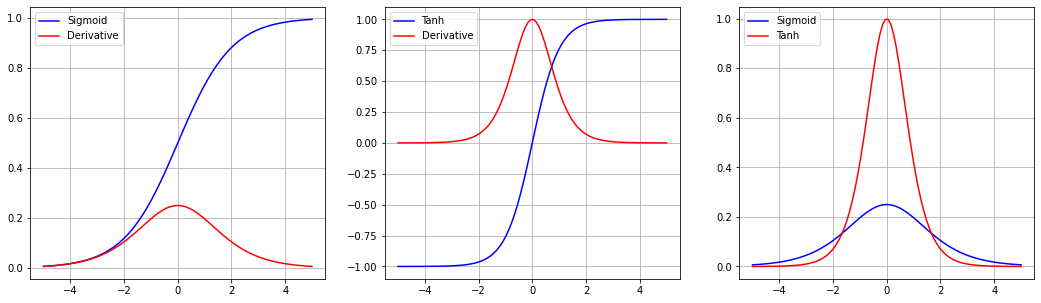

In [10]:
a = np.linspace(-5, 5, 100)
fig = plt.figure(figsize=(18, 5))

plot_activations(fig, a, lambda x: sigmoid(x), lambda x: sigmoid(x)*(1 - sigmoid(x)),
                 1, "Sigmoid", "Derivative")
plot_activations(fig, a, lambda x: tanh(x), lambda x: (1 - tanh(x)) * (1 + tanh(x)),
                 2, "Tanh", "Derivative")
plot_activations(fig, a, lambda x: sigmoid(x)*(1 - sigmoid(x)), lambda x: (1 - tanh(x)) * (1 + tanh(x)),
                 3, "Sigmoid", "Tanh")

plt.show()

Back to the model implementation, define the dimensions of the network.

In [11]:
def define_dimensions(X, Y, n_h):
  """
  Function to define the model's dimensions.

  Arguments:
  X : the dataset of shape: (input size = n_x, number of examples)
  Y : labels vector of shape: (output size = n_y, number of examples)
  n_h : the size of the hidden layer

  Returns:
  dimensions: dictionary containing the model's dimensions
  """
  n_x = X.shape[0]
  n_y = Y.shape[0]

  dimensions = {"n_x": n_x, "n_h": n_h, "n_y": n_y}

  return dimensions


Initialize the parameters in the neural network and use the Xavier weight initialization method. This will become more useful in the context of a **deep** neural network.

In [12]:
def init_parameters(dimensions):
  """
  Initializes the model's parameters.

  Arguments:
  dimensions : the dimensions of the model

  Returns:
  params: dictionary containing initialized parameters:
          -> w1 = weight matrix of shape: (n_h, n_x)
          -> b1 = bias vector of shape: (n_h, 1)
          -> w2 = weight matrix of shape: (n_y, n_h)
          -> b2 = bias vector of shaoe: (n_y, 1)
          where n_x = input size, n_h = hidden layer size, n_y = output size
  """
  n_x = dimensions["n_x"]
  n_h = dimensions["n_h"]
  n_y = dimensions["n_y"]

  W1 = np.random.randn(n_h, n_x) * np.sqrt(1 / n_x)
  b1 = np.zeros((n_h, 1))
  W2 = np.random.randn(n_y, n_h) * np.sqrt(1 / n_h)
  b2 = np.zeros((n_y, 1))

  parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

  return parameters

Define forward and back propagation procedures.

In [13]:
def forward(X, parameters):
  """
  Forward propagation on the model.

  Arguments:
  X : input data of size: (n_x, m)
  parameters: dictionary containing the parameters

  Returns:
  cache : dictionary containing Z1, A1, Z2, A2
  """
  
  m = X.shape[1]

  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]

  Z1 = np.dot(W1, X) + b1
  A1 = tanh(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = sigmoid(Z2)

  cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

  return cache

Note that the backward propagation function has an additional parameter **lambda** which is the coefficient in the L2 regularization (actually the Frobenius Norm of a matrix). L2 regularization is applied to the cost function and also in the backpropagation for dW (db can also be taken into account but it makes no difference). 

The main idea behind this regularization method is that it penalizes large weights ( the square values of the weights in the cost function) for the seek of having a simpler model with smaller weights.

In [14]:
def backward(X, Y, parameters, cache, lambd):
  """
  Backward propagation on the model. 

  Arguments:
  parameters : dictionary containing the parameters
  cache : dictionary containing Z1, A1, Z2, A2
  X : input data of shape: (n_x, number of examples)
  Y : labels vector of shape: (n_y, number of examples)
  
  Returns:
  grads: dictionary containing the gradients w.r.t the parameters
  """
  m = X.shape[1]

  W1 = parameters["W1"]
  W2 = parameters["W2"]
  A1 = cache["A1"]
  A2 = cache["A2"]

  dZ2 = A2 - Y
  dW2 = 1/m * np.dot(dZ2, A1.T) + lambd/m * W2
  db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

  dZ1 = np.dot(W2.T, dZ2) * (1-np.power(A1, 2))
  dW1 = 1/m * np.dot(dZ1, X.T) + lambd/m * W1
  db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

  grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

  return grads

The cost function used for this problem is the binary cross entropy cost. The regularization part is also computed here.

In [15]:
def compute_cost(Y, cache, lambd, parameters):
  """
  Computes the cross-entropy cost.
  
  Arguments:
  Y : labels vector of shape: (n_y, number of examples)
  cache : dictionary containing Z1, A1, Z2, A2
  lambd : Frobenius Norm (~L2 regularization) coefficient
  parameters : dictionary containing parameters

  Returns:
  cost : cross entropy cost
  """
  m = Y.shape[1]
  A2 = cache["A2"]
  cross_entropy_cost = -1/m * (np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2)))
  regularization = 1/m * lambd/2 * (np.sum(np.square(parameters["W1"])) + np.sum(np.square(parameters["W2"])))
  cost = cross_entropy_cost + regularization
  cost = np.squeeze(cost)

  return cost

In [16]:
def optimize(X, Y, parameters, num_iterations, learning_rate, lambd, print_cost):
  """
  Optimizes the model's parameters by running gradient descent.

  Arguments:
  X : input data of shape: (n_x, number of examples)
  Y : labels vector of shape (1, number of examples)
  n_h : number of units in the hidden layer
  num_iterations : number of iterations
  learning_rate : learning rate of the update rule
  lambd : Frobenius Norm (~L2 regularization) coefficient
  print_cost : prints the cost afer 5000 iterations

  Returns:
  parameters : dictionary of learned parameters
  grads : dictionary of gradients
  costs : list containing the cost per 1000 iterations
  """
  
  costs = []

  for i in range(num_iterations):
    # Forward propagation
    cache = forward(X, parameters)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    cost = compute_cost(Y, cache, lambd, parameters)

    # Backward propagation
    grads = backward(X, Y, parameters, cache, lambd)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Update rule: Gradient descent
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    if i % 100 == 0:
      costs.append(cost)

    if i % 5000 == 0 and print_cost is True:
      print("Cost after iteration ", i, ": ", cost)
    
  return parameters, grads, costs 

Define a function to predict labels using the learned parameters.

In [17]:
def predict(X, parameters):
  """
  Predicts the label for examples using the learned parameters

  Arguments:
  X : input data of shape: (n_x, number of examples)
  parameters : dictionary of parameters

  Returns: dictionary of parameters
  Y_hat :  numpy array of predictions of shape: (1, number_of_examples)
  """

  cache = forward(X, parameters)
  A2 = cache["A2"]
  Y_hat = A2 > .5

  return Y_hat

Put together previously implemented functions in order to build the model and compute its accuracy.

In [18]:
def model(X, Y, n_h=4, num_iterations = 10000, learning_rate = .3, lambd = 0, print_cost = True):
  """
  Builds the neural network model.

  Arguments:
  X : input data of shape: (n_x, number of examples)
  Y : labels vector of shape (1, number of examples)
  n_h : number of units in the hidden layer
  num_iterations : number of iterations
  learning_rate : learning rate of the update rule
  lambd : Frobenius Norm (~L2 regularization) coefficient
  print_cost : prints the cost afer 5000 iterations

  Returns:
  d : dictionary containing information about the model
  """
  dimensions = define_dimensions(X, Y, n_h)

  parameters = init_parameters(dimensions)

  parameters, grads, costs = optimize(X, Y, parameters, num_iterations, learning_rate, lambd, print_cost)
  
  Y_hat = predict(X, parameters)

  model_accuracy = np.mean(np.abs((np.dot(Y,Y_hat.T) + np.dot(1-Y,1-Y_hat.T))/(Y.size)*100))
  
  print("model accuracy: ", model_accuracy, "%")

  d = {"params": parameters, "costs": costs, "learning_rate": learning_rate, 
       "num_iterations": num_iterations}

  return d

In [19]:
# Build a model without regularization
d = model(X, Y, n_h=8, num_iterations=20000, learning_rate=0.3 ,lambd=0, print_cost=True)

Cost after iteration  0 :  0.699368156917938
Cost after iteration  5000 :  0.22501943979730646
Cost after iteration  10000 :  0.21100747100626488
Cost after iteration  15000 :  0.19202377198696946
model accuracy:  93.0 %


In [20]:
# Build a model with regularization
d_reg = model(X, Y, n_h=8, num_iterations=20000, learning_rate=0.3 ,lambd=0.7, print_cost=True)

Cost after iteration  0 :  0.6334403129254057
Cost after iteration  5000 :  0.2274678148907501
Cost after iteration  10000 :  0.22587199077890532
Cost after iteration  15000 :  0.2254422115623707
model accuracy:  92.0 %


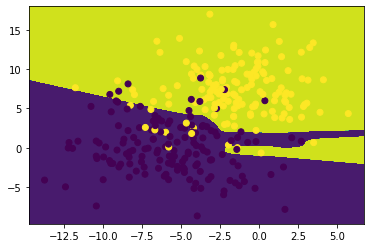

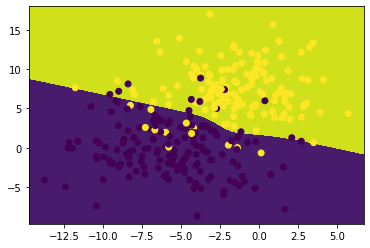

In [21]:
plot_decision_boundary(X, Y, lambda x: predict(x.T, d["params"]))
plt.show()
plot_decision_boundary(X, Y, lambda x: predict(x.T, d_reg["params"]))
plt.show()

We can see that the model without regularization (lambda set to 0) has a higher accuracy, but that comes from the fact that it overfits and learns some noisy points, which will impact the performance on new data. Meanwhile, the model with regularization has a much smoother decision boundary and seems to fit the training data better. *Over smoothing* with a large value for the hyperparameter lambda is also possible, but it can be adjusted by tuning.


Test the model with different numbers of units in the hidden layer. Plot the decision boundaries for each and see how the model behaves. Note how regularization has an important role in a neural network model: **L2 regularization** is particularly used here, but it can be combined with other regularization and optimization techniques.

First without **regularization** and then with.


Hidden layer dimension:  2
Without L2:  model accuracy:  92.0 %
With L2:  model accuracy:  91.0 %

Hidden layer dimension:  4
Without L2:  model accuracy:  91.66666666666666 %
With L2:  model accuracy:  92.0 %

Hidden layer dimension:  8
Without L2:  model accuracy:  92.66666666666666 %
With L2:  model accuracy:  91.33333333333333 %

Hidden layer dimension:  10
Without L2:  model accuracy:  92.66666666666666 %
With L2:  model accuracy:  91.66666666666666 %

Hidden layer dimension:  16
Without L2:  model accuracy:  92.66666666666666 %
With L2:  model accuracy:  91.66666666666666 %

Hidden layer dimension:  20
Without L2:  model accuracy:  93.0 %
With L2:  model accuracy:  91.66666666666666 %

Hidden layer dimension:  25
Without L2:  model accuracy:  92.66666666666666 %
With L2:  model accuracy:  92.0 %

Hidden layer dimension:  32
Without L2:  model accuracy:  93.66666666666667 %
With L2:  model accuracy:  92.0 %

Hidden layer dimension:  50
Without L2:  model accuracy:  93.66666666666

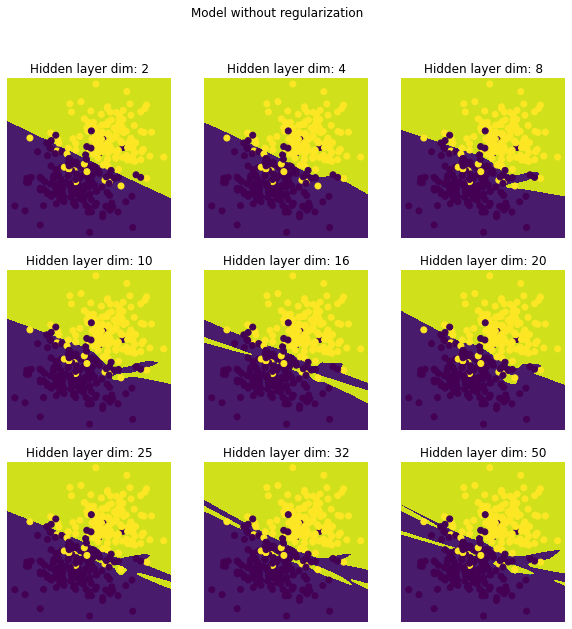

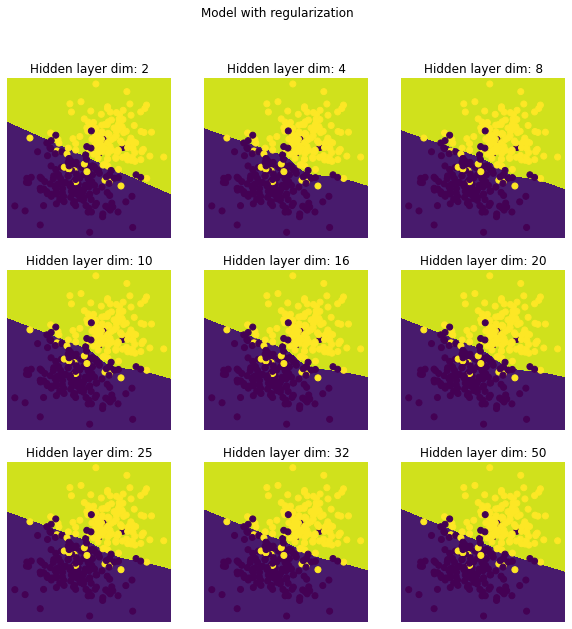

In [22]:
hidden_dimensions = [2, 4, 8, 10, 16, 20, 25, 32, 50]

fig_without_reg = plt.figure(figsize=(10,10))
fig_without_reg.suptitle("Model without regularization")

fig_with_reg = plt.figure(figsize=(10, 10))
fig_with_reg.suptitle("Model with regularization")

rows = 3
columns = 3
j = 1
ax_index = 0
axes_1 = []
axes_2 = []

for dim in hidden_dimensions:
  print("\nHidden layer dimension: ", dim)

  print("Without L2: ", end=' ')
  m_without_reg = model(X, Y, dim, num_iterations=15000, learning_rate=.1, lambd=0, print_cost=False)
  print("With L2: ", end=' ')
  m_with_reg = model(X, Y, dim, num_iterations=15000, learning_rate=.1, lambd=.7, print_cost=False)
 
  axes_1.append(fig_without_reg.add_subplot(rows, columns, j))
  axes_1[ax_index].set_title("Hidden layer dim: " + str(dim))
  axes_1[ax_index].axis("off")

  axes_2.append(fig_with_reg.add_subplot(rows, columns, j))
  axes_2[ax_index].set_title("Hidden layer dim: " + str(dim))
  axes_2[ax_index].axis("off")

  plot_decision_boundary(X, Y, lambda x: predict(x.T, m_without_reg["params"]), ax=axes_1[ax_index])
  plot_decision_boundary(X, Y, lambda x: predict(x.T, m_with_reg["params"]),ax=axes_2[ax_index])
  j += 1
  ax_index += 1

print('\n')
plt.show()

It is obvious how a bigger number of units in the hiden layer can lead to overfitting the data and how regularization helps in achieving a better model with lower variance. Although, in general, an *oversmooth* model having a higher bias will underfit the data. 

Explore other datasets with the current model architecture.

Model for:  moons
model accuracy:  96.33333333333334 %


Model for:  circles
model accuracy:  98.0 %


Model for:  blobs
model accuracy:  91.66666666666666 %


Model for:  gaussian
model accuracy:  98.0 %




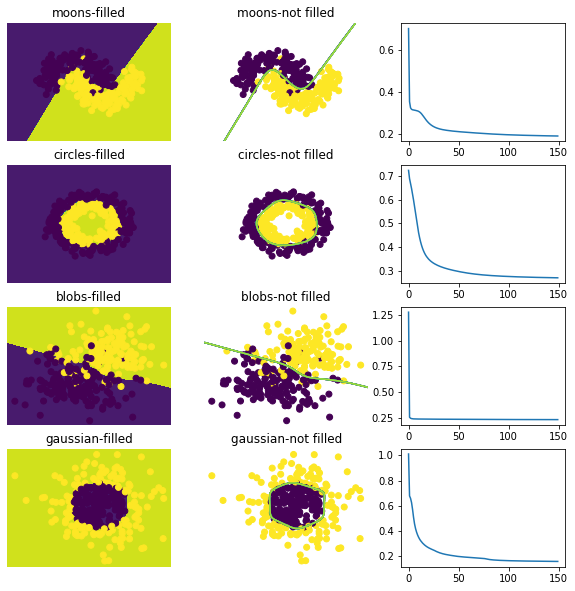

In [23]:
datasets = load_datasets(n_examples)
models = []
for key in datasets:
  print("Model for: ", key)
  model_X_orig = datasets[key][0]
  model_Y_orig = datasets[key][1]
  model_X = model_X_orig.T
  model_Y = model_Y_orig.reshape((1, n_examples))
  model_info = model(model_X, model_Y, n_h=6, num_iterations=15000, learning_rate=.1,lambd=.7, print_cost=False)
  model_info["X"] = model_X
  model_info["Y"] = model_Y
  model_info["dataset_name"] = key
  models.append(model_info)
  print('\n')

fig = plt.figure(figsize=(10, 10))
rows = 4
columns = 3
axes = []
index = 0
i = 1
for m in models:
  # Plot the decision boundary with filled contour
  axes.append(fig.add_subplot(rows, columns, i))
  axes[index].set_title(str(m["dataset_name"]) + "-filled")
  axes[index].axis("off")
  plot_decision_boundary(m["X"], m["Y"], lambda x: predict(x.T, m["params"]))
  index += 1
  i += 1
  # Plot the decision boundary only with the contour
  axes.append(fig.add_subplot(rows, columns, i))
  axes[index].set_title(str(m["dataset_name"]) + "-not filled")
  axes[index].axis("off")
  plot_decision_boundary(m["X"], m["Y"], lambda x: predict(x.T, m["params"]),None, False)
  index += 1
  i += 1
  # Plot the cost function 
  axes.append(fig.add_subplot(rows, columns, i))
  axes[index].axis("on")
  plt.plot(np.squeeze(m["costs"]))
  index += 1
  i += 1

plt.show()